# <span style="color:royalblue"><u>**Comparative Study of Triplets Trading Strategy versus Pairs Trading Strategy (with USO Filter) applied to three commodity-sector exchange-traded funds (GLD, GDX, USO)**</u></span>
## <span style="color:royalblue"> Date: May 2025 </span>

## <span style="color:royalblue"> Abstract </span>

This research presents a comparative analysis between a standalone triplets trading strategy versus a pairs trading strategies enhanced with a USO volatility filter, applied to three commodity-sector exchange-traded funds: SPDR Gold Trust (GLD), VanEck Gold Miners ETF (GDX), and United States Oil Fund (USO). The study evaluates whether the inherent complexity and multi-dimensional relationships captured by triplets trading can outperform the more focused, volatility-filtered pairs approach.

The standalone triplets strategy simultaneously exploits mean reversion opportunities across all three ETFs without external filtering mechanisms, relying purely on the statistical relationships and cointegration vectors between GLD, GDX, and USO. This approach capitalizes on the triangular arbitrage opportunities that emerge when the relative pricing relationships among gold, gold miners, and crude oil deviate from their long-term equilibrium. The strategy operates under the premise that the three-asset framework captures more nuanced market dynamics than bilateral relationships alone.

In contrast, the pairs trading methodology focuses on a two-asset combination (GLD-GDX) while incorporating a sophisticated USO volatility filter that modulates trade execution, position sizing, and risk parameters. The volatility filter acts as a market regime classifier, enhancing trade selection by identifying periods when oil market turbulence signals optimal conditions for pairs convergence trades. This filtered approach prioritizes quality over quantity, seeking to improve hit rates and risk-adjusted performance through selective market timing.

## <span style="color:royalblue"> Imports </span>

In order to view and explore the data, we initially import several python packages. 

This study examines data across all three above-mentioned ETFs for a historical period of two(2) years. 

In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from statsmodels.tsa.stattools import coint, adfuller
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visual style
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

In [2]:
# Define the symbols for the triplet: GLD (Gold ETF), GDX (Gold Miners ETF), USO (Oil ETF)
symbols = ['GLD', 'GDX', 'USO']

## <span style="color:royalblue"> Raw Data </span>

We have sourced raw price data from Yahoo Finance via the yfinance package.

Using the pandas read_csv() method we read the raw input csv file into the raw DataFrame noting that the ordering is chronological.

In [3]:
data = pd.read_csv('project_data_2_years.csv', header=0, index_col=0, parse_dates=True).dropna()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2023-05-22 to 2025-05-19
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GLD     500 non-null    float64
 1   GDX     500 non-null    float64
 2   USO     500 non-null    float64
dtypes: float64(3)
memory usage: 15.6 KB


An inspection of the raw DataFrame using the info() method displays the features of the raw data.
The DataFrame is correctly interpreted by pandas as a <class 'pandas.core.frame.DataFrame'> with DatetimeIndex and there are no missing data points in any of the columns.

## <span style="color:royalblue"> Visualization</span>

Next, we explore the price evolution of all three ETFs over the time period by plotting the Raw Close Price Level columns below.


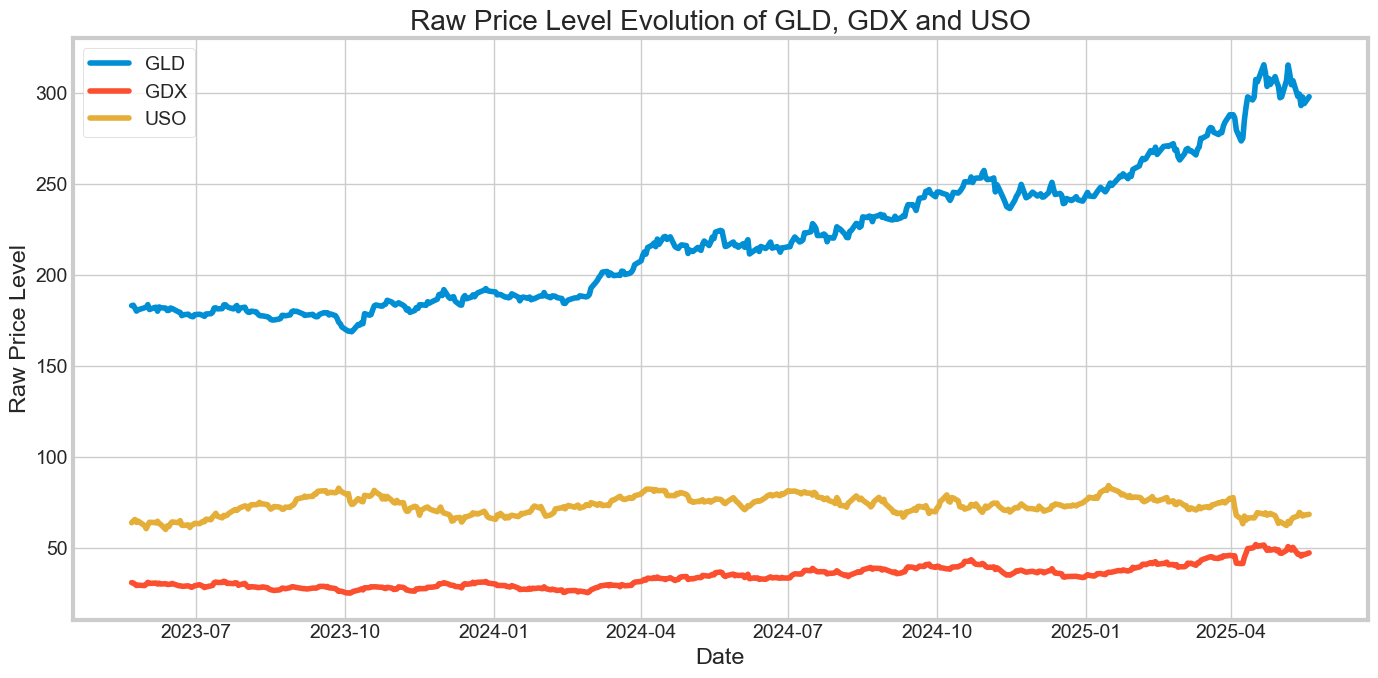

In [5]:
# Plot the price series
plt.figure(figsize=(14, 7))
for symbol in symbols:
    plt.plot(data.index, data[symbol], label=symbol)
plt.title('Raw Price Level Evolution of GLD, GDX and USO')
plt.xlabel('Date')
plt.ylabel('Raw Price Level')
plt.legend()
plt.tight_layout()
plt.show()

Finally we plot the normalized price evolution of all three ETFs over the time period by plotting the Normalized Close Price columns below.


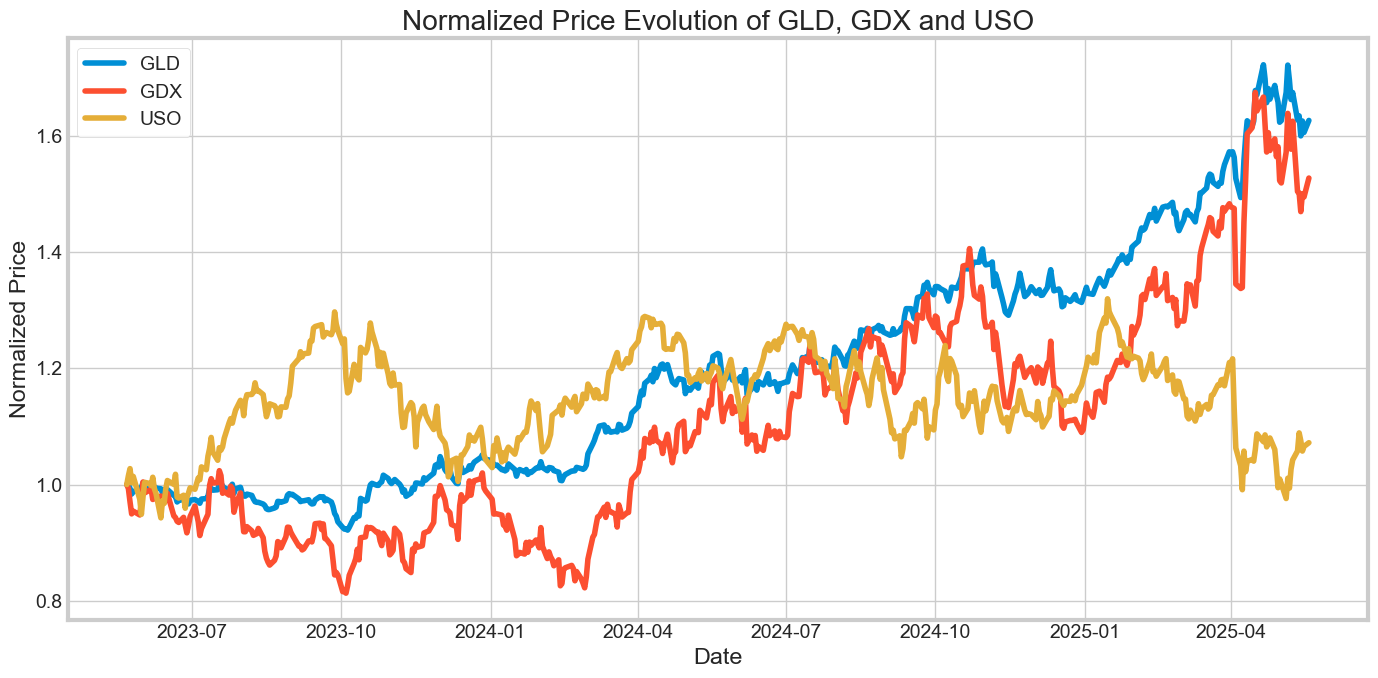

In [6]:
# Plot the normalized price series
plt.figure(figsize=(14, 7))
for symbol in symbols:
    plt.plot(data.index, data[symbol]/data[symbol].iloc[0], label=symbol)
plt.title('Normalized Price Evolution of GLD, GDX and USO')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.tight_layout()
plt.show()

## <span style="color:royalblue">  Data Analytics </span>
The top 3 rows of the <code>data</code> DataFrame are displayed below:

In [7]:
data.head(3)

,GLD,GDX,USO
Date,,,
2023-05-22,183.210007,30.991301,63.910000
2023-05-23,183.429993,30.777365,64.870003
2023-05-24,181.949997,30.067492,65.660004


The relevant statistical properties of the data are revelaed below.

In [8]:
data.describe()

,GLD,GDX,USO
count,500.000000,500.000000,500.000000
mean,219.220880,34.325367,73.266300
std,37.018799,6.146098,4.983881
min,168.830002,25.195625,60.240002
25%,184.112495,28.854388,69.949999
50%,215.824997,33.766808,73.340000
75%,245.032505,38.362129,76.930000
max,315.589996,51.910000,84.339996


## <span style="color:royalblue"> <u>Part 1: Triplets Trading Strategy for all three ETFs (GDX, GLD, USO)</u> </span>

### <span style="color:royalblue"> 1-a. Cointegration Analysis </span>

We define a custom function to check for pairwise cointegration across all three ETFs using the CADF test.

In [9]:
def check_pairwise_cointegration(data, symbols):
    n = len(symbols)
    results = np.zeros((n, n))
    pvalues = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            score, pvalue, _ = coint(data[symbols[i]], data[symbols[j]])
            results[i, j] = score
            pvalues[i, j] = pvalue
            
    return pvalues

In [10]:
# Check pairwise cointegration
pvalues = check_pairwise_cointegration(data, symbols)
print("\nPairwise Cointegration p-values:")
for i in range(len(symbols)):
    for j in range(i+1, len(symbols)):
        print(f"{symbols[i]} - {symbols[j]}: {pvalues[i, j]:.4f}")


Pairwise Cointegration p-values:
GLD - GDX: 0.0343
GLD - USO: 0.9935
GDX - USO: 0.9497


On the basis of above p-values, we can conclude the following:

o	GLD-GDX: This pair is Cointegrated (as p-value is very low)

o	GLD-USO: This pair is Not cointegrated

o	GDX-USO: This pair is Not cointegrated

### <span style="color:royalblue"> 1-b. Calculate the spread using a linear combination of all three assets </span>

We'll use the first asset (GLD) as a reference and build a triplet relationship. 

We will use a user-defined function employing Multiple Linear Regression (Least Squares) for this purpose.

In [11]:
def calculate_triplet_spread(data, symbols):
    X = data[symbols[1:]].values
    y = data[symbols[0]].values
    
    # Fit linear regression to find the relationship
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    
    # Calculate the spread
    spread = y - np.dot(X, beta)
    
    return spread, beta

In [12]:
spread, betas = calculate_triplet_spread(data, symbols)
print(f"\nRegression coefficients: {symbols[1]}: {betas[0]:.4f}, {symbols[2]}: {betas[1]:.4f}")


Regression coefficients: GDX: 5.7649, USO: 0.2921


We now check if the spread (as calculated above) is stationary.

### <span style="color:royalblue"> Necessary Condition: Check for Stationary Spread</span>

In [13]:
# Check if the spread is stationary (key requirement for pairs trading)
adf_result = adfuller(spread)
print(f"\nADF test p-value for spread: {adf_result[1]:.4f}")


ADF test p-value for spread: 0.0055


The p-value is nearly equal to zero, which gives us further confidence that the spread is indeed stationary.

### <span style="color:royalblue"> 1-c. Z-score calculation </span>

We employ a user-defined function to calculate the Z-score of this spread.

In [14]:
def calculate_zscore(spread, window=20):
    rolling_mean = pd.Series(spread).rolling(window=window).mean()
    rolling_std = pd.Series(spread).rolling(window=window).std()
    z_score = (pd.Series(spread) - rolling_mean) / rolling_std
    return z_score

In [15]:
z_score = calculate_zscore(spread)

### <span style="color:royalblue"> 1-d. Define the triplet trading strategy </span>

Triplet Trading Strategy is defined as indicated in the docstring below.

Initial values of trade params ( entry/exit/stop-loss) are assumed zero for convenience.

The optimal values of these params is determined by parameter optimization, as shown subsequently.

In [16]:
def triplet_trading_strategy(data, z_score, entry_threshold=0.0, exit_threshold=0.0, 
                            stop_loss=0.0, window=20):
    """
    Triplet Trading Strategy:
    - Go long on the spread when z-score < -entry_threshold
    - Go short on the spread when z-score > entry_threshold
    - Exit when z-score crosses exit_threshold in the opposite direction
    - Apply stop-loss when z-score exceeds stop_loss level
    """
    positions = np.zeros(len(z_score))
    
    # Initial position: no trade (0)
    for i in range(window, len(z_score)):
        # If no position is held
        if positions[i-1] == 0:
            # Enter long position on spread
            if z_score[i] < -entry_threshold:
                positions[i] = 1
            # Enter short position on spread
            elif z_score[i] > entry_threshold:
                positions[i] = -1
            # Hold cash
            else:
                positions[i] = 0
                
        # If currently in a long position on the spread
        elif positions[i-1] == 1:
            # Exit if z-score crosses exit_threshold from below
            if z_score[i] >= exit_threshold:
                positions[i] = 0
            # Stop loss if spread drops further
            elif z_score[i] < -stop_loss:
                positions[i] = 0
            # Maintain position
            else:
                positions[i] = 1
                
        # If currently in a short position on the spread
        elif positions[i-1] == -1:
            # Exit if z-score crosses exit_threshold from above
            if z_score[i] <= exit_threshold:
                positions[i] = 0
            # Stop loss if spread increases further
            elif z_score[i] > stop_loss:
                positions[i] = 0
            # Maintain position
            else:
                positions[i] = -1
    
    return positions

In [17]:
# Implement the strategy
positions = triplet_trading_strategy(data, z_score.values)
pd.DataFrame(positions).to_csv('triplet_positions.csv')

### <span style="color:royalblue"> 1-e. Calculate returns of the strategy </span>

In [18]:
def calculate_spread_returns(spread, positions):
    # Calculate daily changes in the spread
    spread_changes = np.diff(spread)
    
    # Align positions with spread changes
    strategy_returns = positions[:-1] * spread_changes
    
    return strategy_returns

In [19]:
spread_returns = calculate_spread_returns(spread, positions)

### <span style="color:royalblue"> 1-f. Calculate position values for each asset </span>

In [20]:
def calculate_position_values(data, symbols, positions, betas):
    position_values = pd.DataFrame(index=data.index[1:], columns=symbols)
    
    # Position in the first asset (reference)
    position_values[symbols[0]] = -positions[:-1]
    
    # Positions in other assets based on betas
    for i, symbol in enumerate(symbols[1:]):
        position_values[symbol] = positions[:-1] * betas[i]
    
    return position_values

In [21]:
position_values = calculate_position_values(data, symbols, positions, betas)

### <span style="color:royalblue"> 1-g. Calculate strategy P&L </span>

In [22]:
def calculate_strategy_pnl(data, position_values):
    # Calculate daily returns for each asset
    asset_returns = data.pct_change().iloc[1:]
    
    # Calculate daily P&L as the dot product of positions and returns
    daily_pnl = (position_values * asset_returns).sum(axis=1)
    
    # Calculate cumulative P&L
    cumulative_pnl = daily_pnl.cumsum()
    
    return daily_pnl, cumulative_pnl

In [23]:
daily_pnl, cumulative_pnl = calculate_strategy_pnl(data, position_values)

### <span style="color:royalblue"> 1-h. Calculate strategy metrics </span>

Risk-free rate is assumed to be 3% p.a.

In [24]:
def calculate_metrics(returns, risk_free_rate=0.03/252):
    """Calculate key performance metrics for the strategy"""
    
    # Total Return
    total_return = returns.sum()
    
    # Annualized Return
    annualized_return = returns.mean() * 252
    
    # Volatility (annualized)
    volatility = returns.std() * np.sqrt(252)
    
    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility if volatility > 0 else 0
    
    # Sortino Ratio - only considers downside volatility
    downside_returns = returns.copy()
    downside_returns[downside_returns > 0] = 0
    downside_volatility = downside_returns.std() * np.sqrt(252)
    sortino_ratio = (annualized_return - risk_free_rate) / downside_volatility if downside_volatility > 0 else 0
    
    # Maximum Drawdown
    cumulative = (1 + returns).cumprod()
    peak = cumulative.expanding().max()
    drawdown = (cumulative / peak - 1)
    max_drawdown = drawdown.min()
    
    # Calmar Ratio
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Win Rate
    trades = returns[returns != 0]
    win_rate = len(trades[trades > 0]) / len(trades) if len(trades) > 0 else 0
    
    # Profit Factor
    gross_profits = returns[returns > 0].sum()
    gross_losses = abs(returns[returns < 0].sum())
    profit_factor = gross_profits / gross_losses if gross_losses != 0 else float('inf')
    
    # Average Profit per Trade
    avg_profit = trades.mean() if len(trades) > 0 else 0
    
    # Number of Trades
    num_trades = len(np.where(np.diff(positions) != 0)[0])
    
    metrics = {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Volatility (annualized)': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar_ratio,
        'Win Rate': win_rate,
        'Profit Factor': profit_factor,
        'Average Profit per Trade': avg_profit,
        'Number of Trades': num_trades,
    }
    
    return metrics

In [25]:
strategy_metrics = calculate_metrics(daily_pnl)

In [26]:
### Print the metrics
print("\nStrategy Performance Metrics:")
for metric, value in strategy_metrics.items():
    if metric in ['Win Rate']:
        print(f"{metric}: {value:.2%}")
    elif metric in ['Total Return', 'Max Drawdown']:
        print(f"{metric}: {value:.2%}")
    elif 'Ratio' in metric or 'Factor' in metric:
        print(f"{metric}: {value:.2f}")
    elif metric == 'Number of Trades':
        print(f"{metric}: {int(value)}")
    else:
        print(f"{metric}: {value:.4f}")


Strategy Performance Metrics:
Total Return: 197.52%
Annualized Return: 0.9975
Volatility (annualized): 1.2503
Sharpe Ratio: 0.80
Sortino Ratio: 1.20
Max Drawdown: -80.03%
Calmar Ratio: 1.25
Win Rate: 54.58%
Profit Factor: 1.21
Average Profit per Trade: 0.0082
Number of Trades: 480


It is clear from the above metrics that there seems to be some level of over-trading prevalent (with 480 trades in 2 years period).

### <span style="color:royalblue"> 1-i. Visualize the Results </span>

In [27]:
def visualize_results(data, z_score, positions, cumulative_pnl):
    fig, axs = plt.subplots(3, 1, figsize=(14, 18), gridspec_kw={'height_ratios': [2, 1, 2]})
    
    # Plot 1: Asset prices
    for symbol in symbols:
        axs[0].plot(data.index, data[symbol]/data[symbol].iloc[0], label=symbol)
    axs[0].set_title('Normalized Asset Prices')
    axs[0].set_ylabel('Normalized Price')
    axs[0].legend()
    
    # Plot 2: Z-score and positions
    axs[1].plot(data.index[20:], z_score[20:], color='blue', alpha=0.5)
    axs[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axs[1].axhline(y=2, color='red', linestyle='--', alpha=0.3)
    axs[1].axhline(y=-2, color='green', linestyle='--', alpha=0.3)
    
    # Overlay positions (buy/sell signals)
    buy_signals = np.where(np.diff(np.append(0, positions)) > 0)[0]
    sell_signals = np.where(np.diff(np.append(0, positions)) < 0)[0]
    
    if len(buy_signals) > 0:
        axs[1].scatter(data.index[buy_signals], z_score[buy_signals], color='green', marker='^', s=100, label='Buy Signal')
    if len(sell_signals) > 0:
        axs[1].scatter(data.index[sell_signals], z_score[sell_signals], color='red', marker='v', s=100, label='Sell Signal')
    
    axs[1].set_title('Z-score and Trading Signals')
    axs[1].set_ylabel('Z-score')
    axs[1].legend()
    
    # Plot 3: Cumulative P&L
    axs[2].plot(cumulative_pnl.index, cumulative_pnl, color='blue')
    axs[2].fill_between(cumulative_pnl.index, cumulative_pnl, 0, alpha=0.2, color='blue')
    axs[2].set_title('Cumulative P&L')
    axs[2].set_ylabel('Cumulative P&L')
    axs[2].set_xlabel('Date')
    
    plt.tight_layout()
    plt.show()

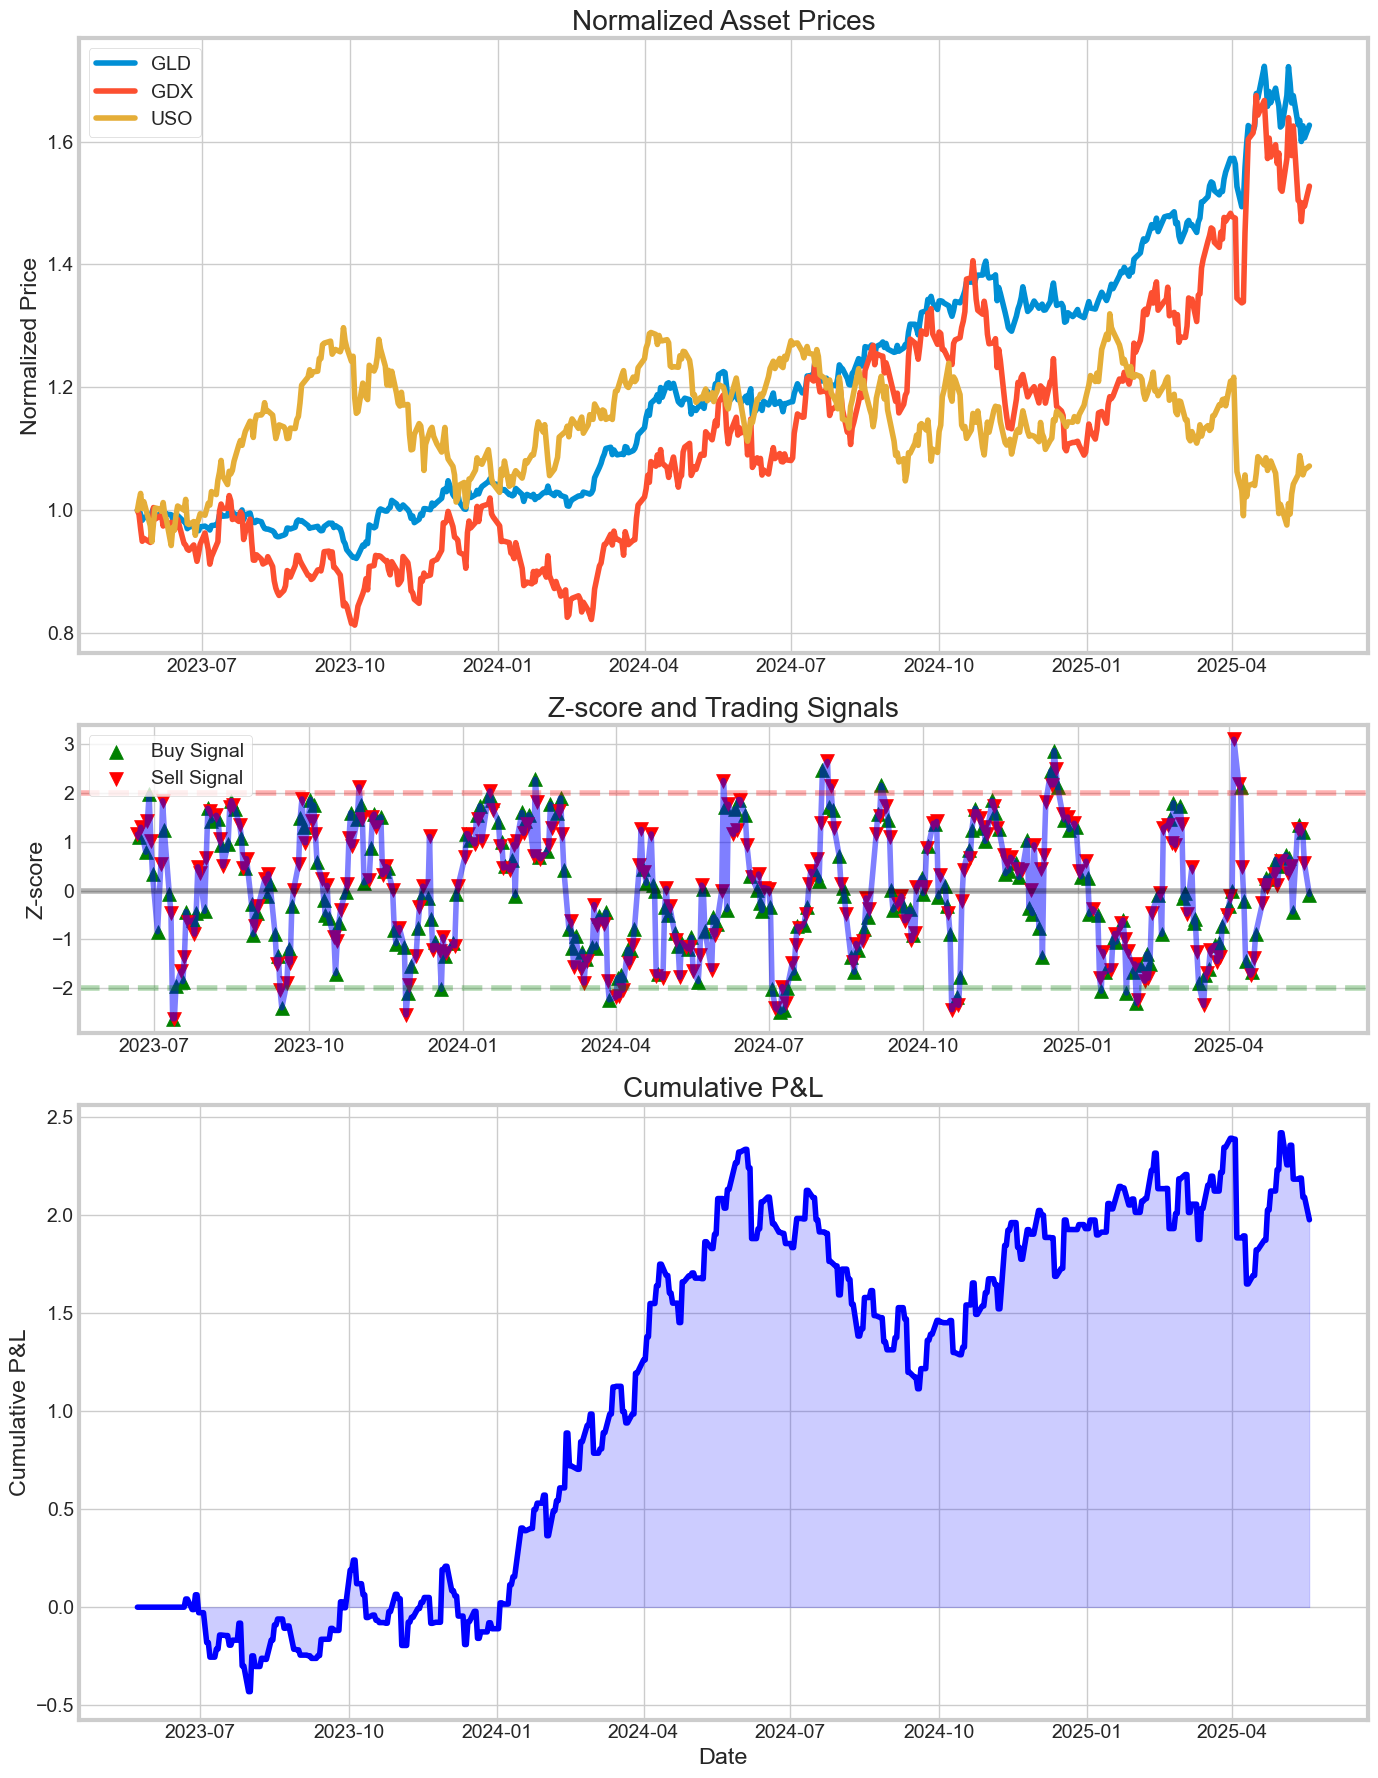

In [28]:
# Visualize the results
visualize_results(data, z_score, positions, cumulative_pnl)

### <span style="color:royalblue"> 1-j. Perform a rolling window analysis to test robustness</span>

In [29]:
def rolling_window_metrics(data, symbols, window_size=126, step_size=21):
    """Calculate metrics using rolling windows to test strategy robustness"""
    
    start_indices = range(0, len(data) - window_size, step_size)
    rolling_metrics = []
    
    for start_idx in start_indices:
        end_idx = start_idx + window_size
        window_data = data.iloc[start_idx:end_idx]
        
        # Calculate spread for this window
        X = window_data[symbols[1:]].values
        y = window_data[symbols[0]].values
        beta = np.linalg.lstsq(X, y, rcond=None)[0]
        spread = y - np.dot(X, beta)
        
        # Calculate z-score
        z_score = calculate_zscore(spread)
        
        # Run strategy
        positions = triplet_trading_strategy(window_data, z_score.values)
        
        # Calculate returns
        spread_returns = calculate_spread_returns(spread, positions)
        
        # Calculate position values
        position_values = pd.DataFrame(index=window_data.index[1:], columns=symbols)
        position_values[symbols[0]] = -positions[:-1]
        for i, symbol in enumerate(symbols[1:]):
            position_values[symbol] = positions[:-1] * beta[i]
        
        # Calculate strategy P&L
        asset_returns = window_data.pct_change().iloc[1:]
        daily_pnl = (position_values * asset_returns).sum(axis=1)
        
        # Calculate metrics
        metrics = calculate_metrics(daily_pnl)
        metrics['Start Date'] = window_data.index[0].strftime('%Y-%m-%d')
        metrics['End Date'] = window_data.index[-1].strftime('%Y-%m-%d')
        
        rolling_metrics.append(metrics)
    
    return pd.DataFrame(rolling_metrics)

In [30]:
# Calculate rolling window metrics
rolling_metrics = rolling_window_metrics(data, symbols)

In [31]:
# Print summary statistics for the rolling metrics
print("\nRolling Window Analysis (6-month windows with 1-month steps):")
metrics_summary = rolling_metrics[['Sharpe Ratio', 'Sortino Ratio', 'Win Rate', 'Max Drawdown']].describe()
print(metrics_summary)


Rolling Window Analysis (6-month windows with 1-month steps):
       Sharpe Ratio  Sortino Ratio   Win Rate  Max Drawdown
count     18.000000      18.000000  18.000000     18.000000
mean      -0.218030      -0.166174   0.487421     -0.486305
std        1.209117       1.779925   0.074985      0.161841
min       -2.163375      -2.812592   0.415094     -0.749472
25%       -1.082148      -1.500175   0.433962     -0.646962
50%        0.014172       0.027871   0.471698     -0.448523
75%        0.514521       0.842729   0.509434     -0.388564
max        2.648117       4.543414   0.716981     -0.215665


### <span style="color:royalblue">1-k. Correlation Analysis</span>

In [32]:
correlations = data.pct_change().corr()
print("\nCorrelation Matrix:")
print(correlations)


Correlation Matrix:
          GLD       GDX       USO
GLD  1.000000  0.805243  0.219075
GDX  0.805243  1.000000  0.195759
USO  0.219075  0.195759  1.000000


We note the high positive correlation (0.8052) between GLD and GDX

We also note the relatively low positive correlation between GLD-USO (0.2190) and GDX-USO (0.1957)

### <span style="color:royalblue"> 1-l. Strategy sensitivity analysis</span>

We run a simple parameter optimization to determine the optimal values of the trade entry and trade exit params.

In [33]:
def analyze_parameter_sensitivity(data, symbols, params_range):
    """Analyze how strategy performance varies with different parameters"""
    results = []
    
    X = data[symbols[1:]].values
    y = data[symbols[0]].values
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    spread = y - np.dot(X, beta)
    z_score = calculate_zscore(spread)
    
    for entry in params_range['entry']:
        for exit in params_range['exit']:
            for stop in params_range['stop']:
                positions = triplet_trading_strategy(data, z_score.values, 
                                                   entry_threshold=entry,
                                                   exit_threshold=exit,
                                                   stop_loss=stop)
                
                spread_returns = calculate_spread_returns(spread, positions)
                
                position_values = pd.DataFrame(index=data.index[1:], columns=symbols)
                position_values[symbols[0]] = -positions[:-1]
                for i, symbol in enumerate(symbols[1:]):
                    position_values[symbol] = positions[:-1] * beta[i]
                
                asset_returns = data.pct_change().iloc[1:]
                daily_pnl = (position_values * asset_returns).sum(axis=1)
                
                metrics = calculate_metrics(daily_pnl)
                metrics['Entry Threshold'] = entry
                metrics['Exit Threshold'] = exit
                metrics['Stop Loss'] = stop
                
                results.append(metrics)
    
    return pd.DataFrame(results)

In [35]:
# Define parameter ranges for sensitivity analysis
params_range = {
    'entry': list(np.arange(0.5, 5.5, 0.5)),
    'exit': list(np.arange(0.1, 1.1, 0.1)),
    'stop': list(np.arange(0.5, 5.5, 0.5)) 
}

We are testing a total of 1000 ( ==10 x 10 x 10 ) parameter combinations.

In [36]:
# Run parameter sensitivity analysis
sensitivity_results = analyze_parameter_sensitivity(data, symbols, params_range)

In [37]:
# Find optimal parameters
optimal_params = sensitivity_results.sort_values('Sharpe Ratio', ascending=False).iloc[0]
print("\nOptimal Strategy Parameters:")
print(f"Entry Threshold: {optimal_params['Entry Threshold']:.1f}")
print(f"Exit Threshold: {optimal_params['Exit Threshold']:.1f}")
print(f"Stop Loss: {optimal_params['Stop Loss']:.1f}")
print(f"Resulting Sharpe Ratio: {optimal_params['Sharpe Ratio']:.2f}")
print(f"Resulting Sortino Ratio: {optimal_params['Sortino Ratio']:.2f}")


Optimal Strategy Parameters:
Entry Threshold: 2.5
Exit Threshold: 1.0
Stop Loss: 2.0
Resulting Sharpe Ratio: 0.86
Resulting Sortino Ratio: 2.76


### <span style="color:royalblue"> 1-m. Analyze drawdowns periods</span>

In [38]:
def analyze_drawdowns(returns, top_n=3):
    """Identify and analyze the largest drawdown periods"""
    # Calculate cumulative returns
    cum_returns = (1 + returns).cumprod()
    
    # Calculate drawdowns
    peak = cum_returns.expanding().max()
    drawdown = (cum_returns / peak - 1)
    
    # Find drawdown periods
    is_in_drawdown = drawdown < 0
    
    # Identify drawdown periods
    drawdown_periods = []
    start_idx = None
    
    for i in range(len(drawdown)):
        if is_in_drawdown.iloc[i] and start_idx is None:
            start_idx = i
        elif not is_in_drawdown.iloc[i] and start_idx is not None:
            end_idx = i - 1
            drawdown_value = drawdown.iloc[start_idx:end_idx+1].min()
            duration = end_idx - start_idx + 1
            drawdown_periods.append({
                'start_date': drawdown.index[start_idx],
                'end_date': drawdown.index[end_idx],
                'max_drawdown': drawdown_value,
                'duration': duration
            })
            start_idx = None
    
    # If still in drawdown at the end of the period
    if start_idx is not None:
        end_idx = len(drawdown) - 1
        drawdown_value = drawdown.iloc[start_idx:end_idx+1].min()
        duration = end_idx - start_idx + 1
        drawdown_periods.append({
            'start_date': drawdown.index[start_idx],
            'end_date': drawdown.index[end_idx],
            'max_drawdown': drawdown_value,
            'duration': duration
        })
    
    # Sort by max drawdown (ascending)
    drawdown_periods.sort(key=lambda x: x['max_drawdown'])
    
    return drawdown_periods[:top_n]

In [39]:
# Analyze top drawdown periods
top_drawdowns = analyze_drawdowns(daily_pnl)
print("\nTop 3 Drawdown Periods:")
for i, dd in enumerate(top_drawdowns):
    print(f"{i+1}. {dd['start_date'].strftime('%Y-%m-%d')} to {dd['end_date'].strftime('%Y-%m-%d')}")
    print(f"   Max Drawdown: {dd['max_drawdown']:.2%}")
    print(f"   Duration: {dd['duration']} trading days")


Top 3 Drawdown Periods:
1. 2024-06-05 to 2025-05-19
   Max Drawdown: -80.03%
   Duration: 239 trading days
2. 2023-10-06 to 2024-01-23
   Max Drawdown: -43.03%
   Duration: 74 trading days
3. 2023-06-30 to 2023-10-03
   Max Drawdown: -42.87%
   Duration: 66 trading days


We note that this simple triplet trading strategy seems to have larger drawdowns, with longer time to recovery, implying higher than desirable volatility.

We will proceed to compare this basic triplets strategy with a suitable benchmark- namely an equally weighted protfolio comprising equal weights in each of the three constituent ETFs (namely GLD, GDX, USO)

### <span style="color:royalblue"> 1-n. Compare strategy performance to a benchmark (Equal-weight portfolio)</span>

In [40]:
def compare_to_benchmark(data, daily_pnl):
    """Compare strategy performance to a simple equal-weight portfolio"""
    # Calculate equal-weight portfolio returns
    eq_weight_returns = data.pct_change().mean(axis=1).iloc[1:]
    eq_weight_cumulative = (1 + eq_weight_returns).cumprod()
    
    # Calculate strategy cumulative returns
    strategy_cumulative = (1 + daily_pnl).cumprod()
    
    # Calculate metrics for both
    strategy_metrics = calculate_metrics(daily_pnl)
    benchmark_metrics = calculate_metrics(eq_weight_returns)
    
    # Plot comparison
    plt.figure(figsize=(14, 7))
    plt.plot(strategy_cumulative.index, strategy_cumulative, label='Triplets Strategy')
    plt.plot(eq_weight_cumulative.index, eq_weight_cumulative, label='Equal-Weight Portfolio')
    plt.title('Strategy vs. Benchmark Performance')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Print comparison metrics
    comparison = pd.DataFrame({
        'Triplets Strategy': [
            f"{strategy_metrics['Annualized Return']:.2%}",
            f"{strategy_metrics['Volatility (annualized)']:.2%}",
            f"{strategy_metrics['Sharpe Ratio']:.2f}",
            f"{strategy_metrics['Max Drawdown']:.2%}",
            f"{strategy_metrics['Win Rate']:.2%}"
        ],
        'Equal-Weight Benchmark': [
            f"{benchmark_metrics['Annualized Return']:.2%}",
            f"{benchmark_metrics['Volatility (annualized)']:.2%}",
            f"{benchmark_metrics['Sharpe Ratio']:.2f}",
            f"{benchmark_metrics['Max Drawdown']:.2%}",
            f"{benchmark_metrics['Win Rate']:.2%}"
        ]
    }, index=['Annualized Return', 'Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Win Rate'])
    
    return comparison

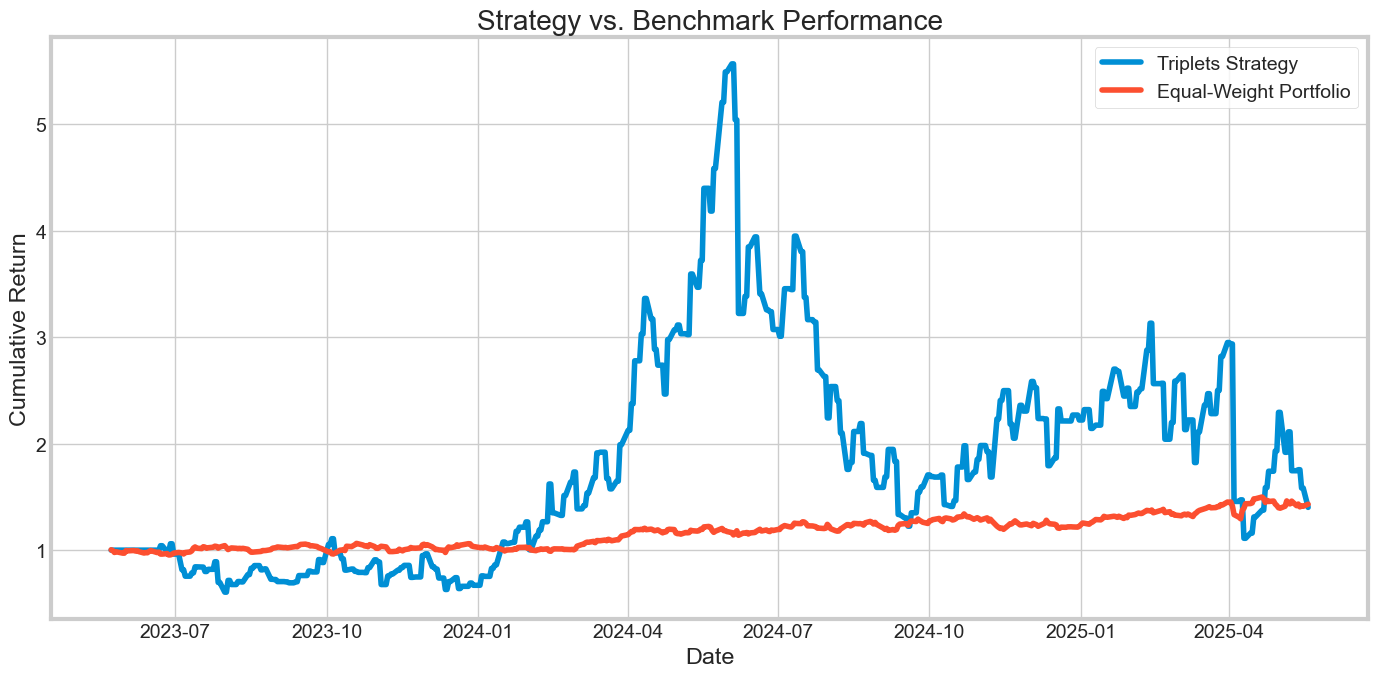


Strategy vs. Benchmark Comparison:
                  Triplets Strategy Equal-Weight Benchmark
Annualized Return            99.75%                 20.05%
Volatility                  125.03%                 19.72%
Sharpe Ratio                   0.80                   1.02
Max Drawdown                -80.03%                -10.86%
Win Rate                     54.58%                 51.70%


In [41]:
# Compare to benchmark
benchmark_comparison = compare_to_benchmark(data, daily_pnl)
print("\nStrategy vs. Benchmark Comparison:")
print(benchmark_comparison)

As noted earlier, the triplets strategy appears to be much more volatile and fluctuating than its equal-weighted benchmark.\
The triplets strategy also suffers from lower risk-adjusted returns (as seen from its slightly lower Sharpe Ratio than benchmark).\
The marginally higher win rate of the triplets strategy is surely not a sufficient reason to favour this strategy (over its benchmark).

### <span style="color:royalblue"> 1-o. Final Triplets Strategy Summary</span>

In [44]:
# 15. Final strategy summary
print("\n=== Final Triplets Trading Strategy Summary ===")
print(f"Assets: {', '.join(symbols)}")
print(f"Period: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
print(f"Regression coefficients: {symbols[1]}: {betas[0]:.4f}, {symbols[2]}: {betas[1]:.4f}")
print(f"Entry threshold: {optimal_params['Entry Threshold']:.1f}")
print(f"Exit threshold: {optimal_params['Exit Threshold']:.1f}")
print(f"Stop loss: {optimal_params['Stop Loss']:.1f}")
print(f"Sharpe ratio: {optimal_params['Sharpe Ratio']:.2f}")
print(f"Total return: {strategy_metrics['Total Return']:.2%}")
print(f"Number of trades: {int(strategy_metrics['Number of Trades'])}")
print(f"Win rate: {strategy_metrics['Win Rate']:.2%}")


=== Final Triplets Trading Strategy Summary ===
Assets: GLD, GDX, USO
Period: 2023-05-22 to 2025-05-19
Regression coefficients: GDX: 5.7649, USO: 0.2921
Entry threshold: 2.5
Exit threshold: 1.0
Stop loss: 2.0
Sharpe ratio: 0.86
Total return: 197.52%
Number of trades: 480
Win rate: 54.58%


## <span style="color:royalblue"><u>Part 2: GLD-GDX Pairs Trading with USO Filter</u> </span>

### <span style="color:royalblue">2-a. Analyze the GLD-GDX pair relationship</span>

In [45]:
def analyze_pairs_trading(data, symbols, lookback=20):
    """Analyze a simple pairs trading strategy for GLD and GDX"""
    # Extract the pair
    pair_data = data[symbols[:2]].copy()
    
    # Check for cointegration
    score, pvalue, _ = coint(pair_data[symbols[0]], pair_data[symbols[1]])
    print(f"Cointegration p-value for {symbols[0]}-{symbols[1]}: {pvalue:.4f}")
    
    # Calculate the hedge ratio using linear regression
    model = np.polyfit(pair_data[symbols[1]], pair_data[symbols[0]], 1)
    hedge_ratio = model[0]
    print(f"Hedge ratio: {hedge_ratio:.4f}")
    
    # Calculate the spread for GLD-GDX pair
    spread = pair_data[symbols[0]] - hedge_ratio * pair_data[symbols[1]]
    
    # Test for stationarity
    adf_result = adfuller(spread)
    print(f"ADF test p-value for spread: {adf_result[1]:.4f}")
    
    # Calculate z-score
    z_score = calculate_zscore(spread, window=lookback)
    
    return pair_data, spread, z_score, hedge_ratio

In [46]:
# Analyze GLD-GDX pair
pair_data, pair_spread, z_score, hedge_ratio = analyze_pairs_trading(data, symbols, lookback=20)

Cointegration p-value for GLD-GDX: 0.0343
Hedge ratio: 5.8145
ADF test p-value for spread: 0.0086


Thus we observe that the ETF pair GLD-GDX appears to be cointegrated, as p-value is close to zero.

The ADF test p-value for the spread between GLD-GDX is also close to zero; which further indicates that this spread is also stationary.

### <span style="color:royalblue"> 2-b. Determine the Threshold for USO Volatility Filter</span>

In [47]:
def find_uso_threshold(data, symbols, spread, z_score):
    """Find an optimal USO threshold for filtering pairs trading"""
    uso = data[symbols[2]].copy()
    
    # Calculate USO returns and volatility
    uso_returns = uso.pct_change().dropna()
    uso_volatility = uso_returns.rolling(window=20).std()
    
    # Calculate USO z-scores based on volatility
    uso_mean = uso_volatility.rolling(window=60).mean()
    uso_std = uso_volatility.rolling(window=60).std()
    uso_z = (uso_volatility - uso_mean) / uso_std
    
    # Analyze how USO volatility affects the spread relationship
    spread_returns = spread.pct_change().dropna()
    
    # Calculate correlation between USO volatility and spread returns
    correlation = uso_volatility.iloc[20:].corr(spread_returns.abs().iloc[20:])
    print(f"\nCorrelation between USO volatility and spread movement: {correlation:.4f}")
    
    # Calculate how USO volatility impacts pairs trading performance
    results = []
    thresholds = np.percentile(uso_volatility.dropna(), [30, 40, 50, 60, 70, 75, 80, 85, 90, 95])
    
    for threshold in thresholds:
        # Create a filter: True when USO volatility is below threshold
        uso_filter = uso_volatility < threshold
        
        # Apply filter to pairs trading strategy
        filtered_strategy_returns = run_filtered_pairs_strategy(pair_data, symbols[:2], spread, z_score, uso_filter)
        
        # Calculate metrics
        metrics = calculate_metrics(filtered_strategy_returns)
        metrics['Threshold'] = threshold
        metrics['Threshold Percentile'] = stats.percentileofscore(uso_volatility.dropna(), threshold)
        metrics['Trade Days'] = len(filtered_strategy_returns[filtered_strategy_returns != 0])
        
        results.append(metrics)
    
    return pd.DataFrame(results), uso_volatility, uso_z

In [48]:
def run_filtered_pairs_strategy(pair_data, pair_symbols, spread, z_score, uso_filter, 
                               entry_threshold=0.0, exit_threshold=0.0, stop_loss=0.0):
    """Run a pairs trading strategy with USO filter"""
    # Initialize positions
    positions = np.zeros(len(z_score))
    
    # Apply trading rules with USO filter
    for i in range(20, len(z_score)):
        # Only trade if USO filter allows (and we have enough data points)
        if i < len(uso_filter) and uso_filter.iloc[i]:
            # If no position is held
            if positions[i-1] == 0:
                # Enter long position on spread
                if z_score[i] < -entry_threshold:
                    positions[i] = 1
                # Enter short position on spread
                elif z_score[i] > entry_threshold:
                    positions[i] = -1
                # Hold cash
                else:
                    positions[i] = 0
                    
            # If currently in a long position on the spread
            elif positions[i-1] == 1:
                # Exit if z-score crosses exit_threshold from below
                if z_score[i] >= exit_threshold:
                    positions[i] = 0
                # Stop loss if spread drops further
                elif z_score[i] < -stop_loss:
                    positions[i] = 0
                # Maintain position
                else:
                    positions[i] = 1
                    
            # If currently in a short position on the spread
            elif positions[i-1] == -1:
                # Exit if z-score crosses exit_threshold from above
                if z_score[i] <= exit_threshold:
                    positions[i] = 0
                # Stop loss if spread increases further
                elif z_score[i] > stop_loss:
                    positions[i] = 0
                # Maintain position
                else:
                    positions[i] = -1
        else:
            # No trading when USO filter is triggered - flat position
            positions[i] = 0

    #return positions        
     
    # Calculate returns
    # Calculate daily changes in the spread
    spread_changes = spread.pct_change().shift(-1).iloc[:-1]
    
    # Align positions with spread changes
    strategy_returns = pd.Series(positions[:-1], index=spread_changes.index) * spread_changes
    pd.Series(positions).to_csv("filtered_pairs_positions.csv")

    return strategy_returns
    #return positions

In [49]:
threshold_results, uso_volatility, uso_z = find_uso_threshold(data, symbols, pair_spread, z_score)


Correlation between USO volatility and spread movement: 0.0041


In [50]:
# Sort by Sharpe Ratio
optimal_threshold = threshold_results.sort_values('Sharpe Ratio', ascending=False).iloc[0]
print("\nOptimal USO Volatility Threshold Results:")
print(f"Threshold value: {optimal_threshold['Threshold']:.6f}")
print(f"Percentile: {optimal_threshold['Threshold Percentile']:.1f}%")
print(f"Sharpe Ratio: {optimal_threshold['Sharpe Ratio']:.2f}")
print(f"Sortino Ratio: {optimal_threshold['Sortino Ratio']:.2f}")
print(f"Win Rate: {optimal_threshold['Win Rate']:.2%}")
print(f"Trading days: {int(optimal_threshold['Trade Days'])} (out of {len(data) - 20})")


Optimal USO Volatility Threshold Results:
Threshold value: 0.013600
Percentile: 30.0%
Sharpe Ratio: 1.27
Sortino Ratio: 4.07
Win Rate: 58.67%
Trading days: 75 (out of 480)


### <span style="color:royalblue">2-c. Run the Optimized Filtered Pairs trading strategy with USO filter</span>

In [51]:
optimal_filter = uso_volatility < optimal_threshold['Threshold']
final_pairs_returns = run_filtered_pairs_strategy(pair_data, symbols[:2], pair_spread, z_score, optimal_filter)
final_pairs_metrics = calculate_metrics(final_pairs_returns)

### <span style="color:royalblue">2-d. Visualize the filtered strategy results</span>

In [64]:
# 4. Visualize the filtered strategy results
def visualize_filtered_strategy(data, symbols, spread, z_score, uso_volatility, uso_filter, strategy_returns, positions):
    fig, axs = plt.subplots(4, 1, figsize=(14, 20), gridspec_kw={'height_ratios': [2, 1, 1, 2]})
    
    # Plot 1: Asset prices
    for symbol in symbols:
        axs[0].plot(data.index, data[symbol]/data[symbol].iloc[0], label=symbol)
    axs[0].set_title('Normalized Asset Prices')
    axs[0].set_ylabel('Normalized Price')
    axs[0].legend()
    
    # Plot 2: Z-score and USO filter
    axs[1].plot(z_score.index, z_score, color='blue', alpha=0.5, label='Spread Z-Score')
    
    # Highlight filtered periods
    uso_filter_series = pd.Series(uso_filter, index=uso_filter.index)
    #print(uso_filter_series)
    filtered_periods = uso_filter_series.iloc[20:].rolling(window=2).apply(lambda x: (x[0] != x[1]) and x[1]).fillna(False)
    #print(filtered_periods)
    filtered_periods_indices = filtered_periods.index
    #print(z_score.index)

    
    for idx in filtered_periods_indices:
        if idx in z_score.index:
            end_idx = uso_filter_series[uso_filter_series.index > idx].idxmax() if len(uso_filter_series[uso_filter_series.index > idx]) > 0 else filtered_periods_indices[-1]
            axs[1].axvspan(idx, end_idx, color='red', alpha=0.2)#, label="NO_TRADE")   
    
    axs[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axs[1].axhline(y=2, color='red', linestyle='--', alpha=0.3)
    axs[1].axhline(y=-2, color='green', linestyle='--', alpha=0.3)
    axs[1].set_title('Z-score and USO Filter (Red Shading = No Trading)')
    axs[1].set_ylabel('Z-score')

    # Overlay positions (buy/sell signals)
    buy_signals = np.where(np.diff(np.append(0, positions)) > 0)[0]
    sell_signals = np.where(np.diff(np.append(0, positions)) < 0)[0]
    
    if len(buy_signals) > 0:
        axs[1].scatter(data.index[buy_signals], z_score[buy_signals], color='green', marker='^', s=100, label='Buy Signal')
    if len(sell_signals) > 0:
        axs[1].scatter(data.index[sell_signals], z_score[sell_signals], color='red', marker='v', s=100, label='Sell Signal')
    
    
    # Plot 3: USO Volatility and Threshold
    axs[2].plot(uso_volatility.index, uso_volatility, color='orange', label='USO Volatility (20-day)')
    axs[2].axhline(y=optimal_threshold['Threshold'], color='red', linestyle='--', 
                    label=f"Threshold ({optimal_threshold['Threshold']:.6f})")
    axs[2].fill_between(uso_volatility.index, uso_volatility, optimal_threshold['Threshold'], 
                    where=uso_volatility>optimal_threshold['Threshold'], color='red', alpha=0.3)
    axs[2].set_title('USO Volatility and Trading Threshold')
    axs[2].set_ylabel('Volatility')
    axs[2].legend()
    
    # Plot 4: Cumulative Returns
    cum_returns = (1+strategy_returns).cumprod()
    #print(strategy_returns)
    #print(cum_returns)
    axs[3].plot(cum_returns.index, cum_returns, color='green')
    axs[3].set_title('Cumulative Returns - Pairs Trading with USO Filter')
    axs[3].set_ylabel('Cumulative Return')
    axs[3].set_xlabel('Date')
    
    plt.tight_layout()
    plt.show()

In [53]:
positions = pd.read_csv('filtered_pairs_positions.csv', header=0, index_col=0)

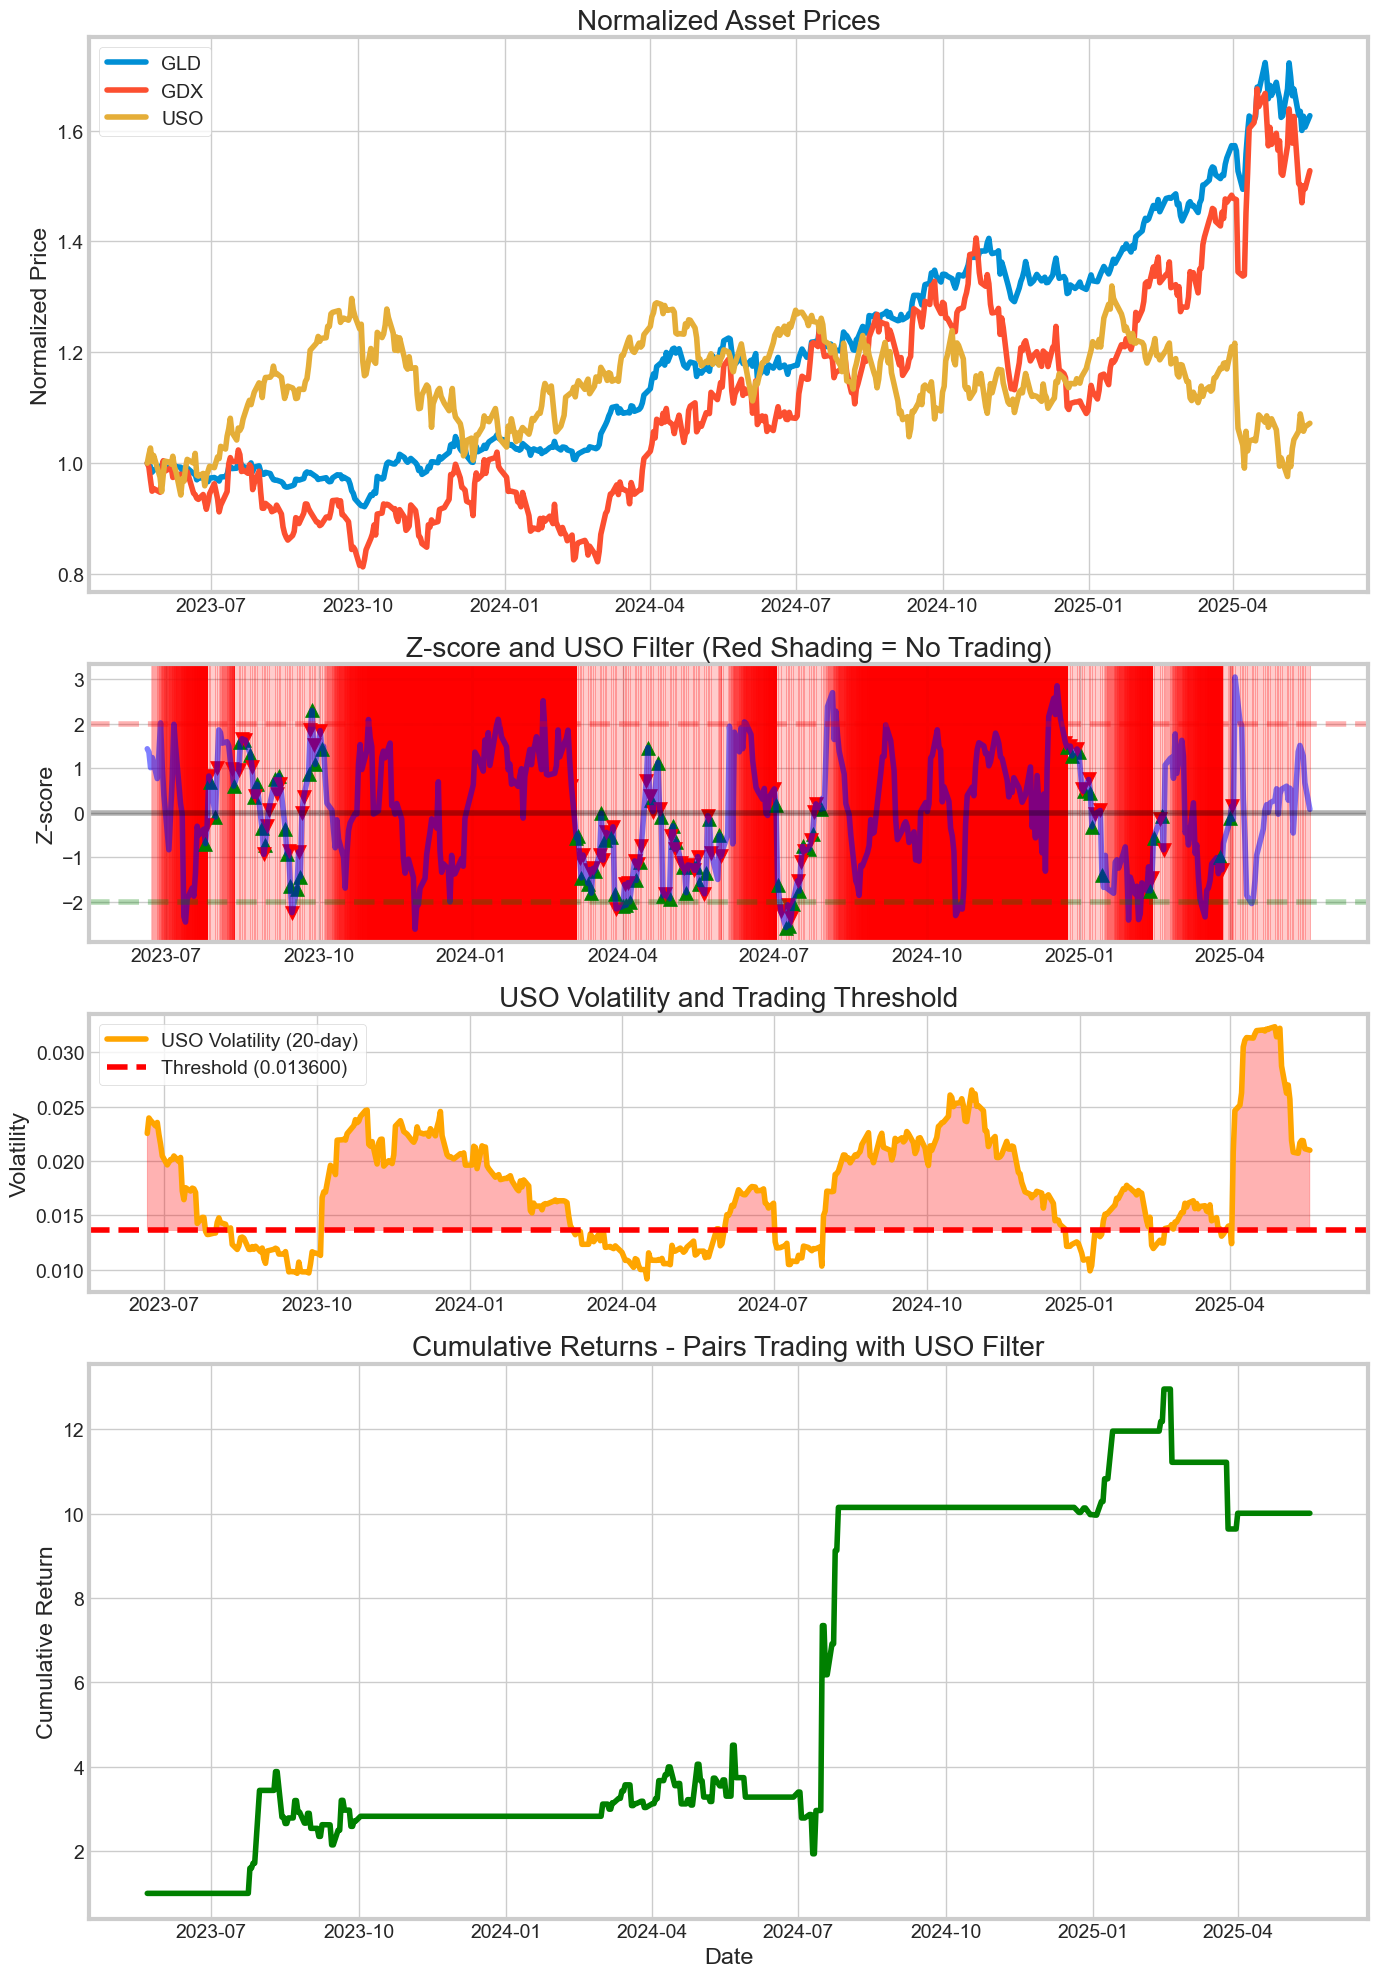

In [65]:
visualize_filtered_strategy(data, symbols, spread, z_score, uso_volatility, optimal_filter, final_pairs_returns, positions)

### <span style="color:royalblue">2-e. Compare Triplets Trading vs. Filtered Pairs trading</span>

In [66]:
def compare_strategies(triplets_pnl, filtered_pairs_returns):
    # Calculate cumulative returns for both strategies
    triplets_cumulative = (1 + triplets_pnl).cumprod()
    pairs_cumulative = (1 + filtered_pairs_returns).cumprod()
    
    # Get metrics
    triplets_metrics = calculate_metrics(triplets_pnl)
    pairs_metrics = calculate_metrics(filtered_pairs_returns)
    #print(pairs_metrics)
    
    # Plot comparison
    plt.figure(figsize=(14, 7))
    plt.plot(triplets_cumulative.index, triplets_cumulative, label='Triplets Strategy')
    plt.plot(pairs_cumulative.index, pairs_cumulative, label='Pairs Trading with USO Filter')
    plt.title('Strategy Comparison: Triplets vs. Filtered Pairs')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Create comparison table
    comparison = pd.DataFrame({
        'Triplets Strategy': [
            f"{triplets_metrics['Total Return']:.2%}",
            f"{triplets_metrics['Annualized Return']:.2%}",
            f"{triplets_metrics['Volatility (annualized)']:.2%}",
            f"{triplets_metrics['Sharpe Ratio']:.2f}",
            f"{triplets_metrics['Sortino Ratio']:.2f}",
            f"{triplets_metrics['Max Drawdown']:.2%}",
            f"{triplets_metrics['Win Rate']:.2%}",
            f"{int(optimal_params['Number of Trades'])}"
        ],
        'Pairs with USO Filter': [
            f"{pairs_metrics['Total Return']:.2%}",
            f"{pairs_metrics['Annualized Return']:.2%}",
            f"{pairs_metrics['Volatility (annualized)']:.2%}",
            f"{pairs_metrics['Sharpe Ratio']:.2f}",
            f"{pairs_metrics['Sortino Ratio']:.2f}",
            f"{pairs_metrics['Max Drawdown']:.2%}",
            f"{pairs_metrics['Win Rate']:.2%}",
            f"{int(optimal_threshold['Trade Days'])}"
        ]
    }, index=['Total Return', 'Annualized Return', 'Volatility', 'Sharpe Ratio', 
              'Sortino Ratio', 'Max Drawdown', 'Win Rate', 'Number of Trades'])
    
    print("\nStrategy Comparison:")
    print(comparison)
    
    # Calculate correlation between strategy returns
    common_indices = triplets_pnl.index.intersection(filtered_pairs_returns.index)
    correlation = triplets_pnl[common_indices].corr(filtered_pairs_returns[common_indices])
    print(f"\nCorrelation between strategies: {correlation:.4f}")
    
    # Calculate periods where strategies differ in direction
    direction_agreement = np.sign(triplets_pnl[common_indices]) == np.sign(filtered_pairs_returns[common_indices])
    agree_percent = direction_agreement.mean() * 100
    print(f"Direction agreement: {agree_percent:.1f}%")
    
    return comparison, correlation

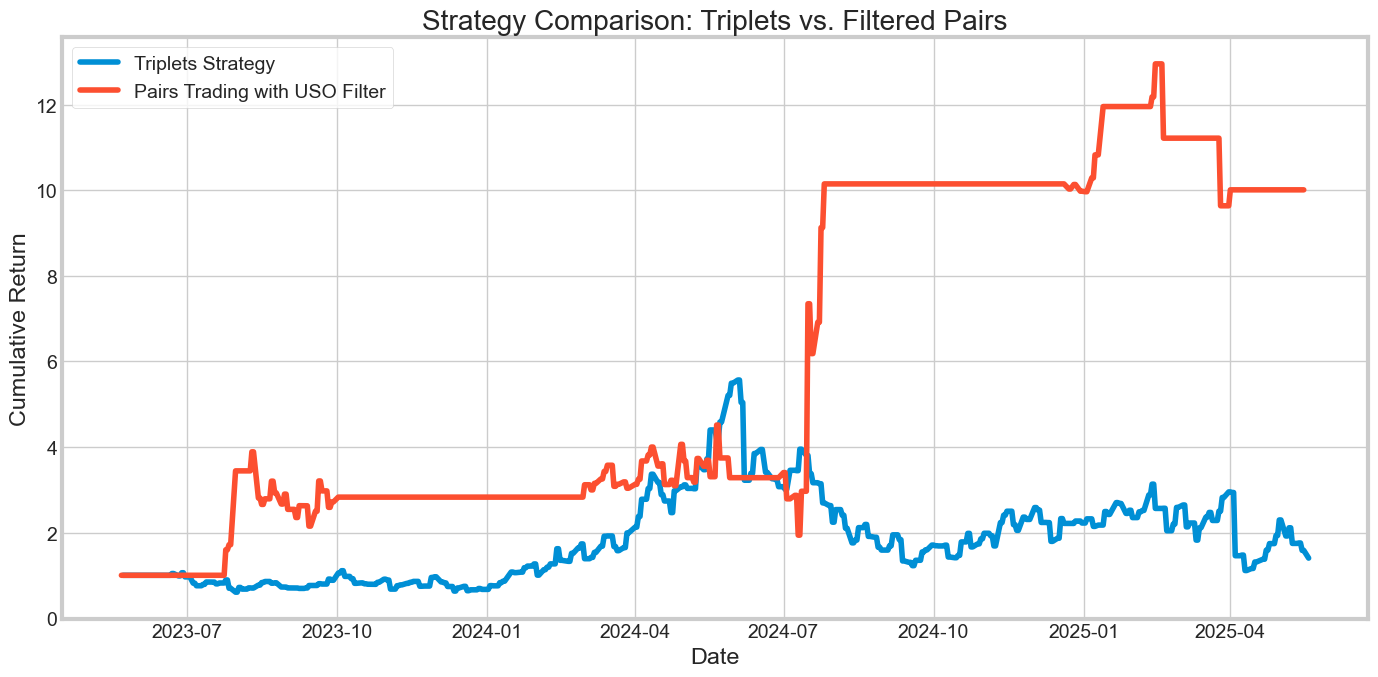


Strategy Comparison:
                  Triplets Strategy Pairs with USO Filter
Total Return                197.52%               398.64%
Annualized Return            99.75%               201.31%
Volatility                  125.03%               158.23%
Sharpe Ratio                   0.80                  1.27
Sortino Ratio                  1.20                  4.07
Max Drawdown                -80.03%               -57.05%
Win Rate                     54.58%                58.67%
Number of Trades                480                    75

Correlation between strategies: -0.0321
Direction agreement: 53.8%


In [67]:
# Compare the strategies
strategy_comparison, strategy_correlation = compare_strategies(daily_pnl, final_pairs_returns)

### <span style="color:royalblue">2-f. Final Analysis and Insights</span>

In [59]:
def analyze_strategy_differences(data, symbols, triplets_pnl, filtered_pairs_returns, uso_filter):
    """Analyze the main differences between the two strategies"""
    # Find periods where strategies significantly differ
    common_indices = triplets_pnl.index.intersection(filtered_pairs_returns.index)
    
    # Calculate return difference
    return_diff = triplets_pnl[common_indices] - filtered_pairs_returns[common_indices]
    
    # Find outlier periods (top 5% differences)
    outlier_threshold = np.percentile(np.abs(return_diff), 95)
    outlier_days = return_diff[np.abs(return_diff) > outlier_threshold]
    
    print("\nPeriods with largest strategy differences:")
    for date, diff in outlier_days.sort_values(ascending=False).items():
        print(f"{date.strftime('%Y-%m-%d')}: Difference of {diff:.2%}")
    
    # Analyze market conditions during those periods
    oil_volatility = data[symbols[2]].pct_change().rolling(window=20).std()
    gold_volatility = data[symbols[0]].pct_change().rolling(window=20).std()
    miners_volatility = data[symbols[1]].pct_change().rolling(window=20).std()
    
    outlier_dates = outlier_days.index
    
    oil_vol_during_outliers = oil_volatility.loc[outlier_dates].mean()
    gold_vol_during_outliers = gold_volatility.loc[outlier_dates].mean()
    miners_vol_during_outliers = miners_volatility.loc[outlier_dates].mean()
    
    oil_vol_avg = oil_volatility.mean()
    gold_vol_avg = gold_volatility.mean()
    miners_vol_avg = miners_volatility.mean()
    
    print("\nMarket conditions during largest strategy differences:")
    print(f"USO volatility: {oil_vol_during_outliers:.4f} (avg: {oil_vol_avg:.4f}, ratio: {oil_vol_during_outliers/oil_vol_avg:.2f}x)")
    print(f"GLD volatility: {gold_vol_during_outliers:.4f} (avg: {gold_vol_avg:.4f}, ratio: {gold_vol_during_outliers/gold_vol_avg:.2f}x)")
    print(f"GDX volatility: {miners_vol_during_outliers:.4f} (avg: {miners_vol_avg:.4f}, ratio: {miners_vol_during_outliers/miners_vol_avg:.2f}x)")
    
    # Check filter effectiveness
    active_filter_days = (~uso_filter).sum()
    filter_percentage = active_filter_days / len(uso_filter) * 100
    
    print(f"\nUSO filter active (no trading) for {filter_percentage:.1f}% of trading days")
    
    # Check if USO filter avoids bad trades
    trades_avoided = len(common_indices) - len(filtered_pairs_returns[filtered_pairs_returns != 0])
    print(f"Trades avoided due to filter: {trades_avoided}")
    print(f"Filter Percentage: {filter_percentage}")
    
    return outlier_days, oil_volatility, filter_percentage


In [60]:
# Analyze differences between strategies
outlier_periods, oil_volatility, filter_perc = analyze_strategy_differences(data, symbols, daily_pnl, final_pairs_returns, optimal_filter)


Periods with largest strategy differences:
2023-08-14: Difference of 37.62%
2024-07-10: Difference of 32.44%
2024-11-11: Difference of 32.36%
2024-05-17: Difference of 28.61%
2024-02-13: Difference of 27.98%
2023-09-26: Difference of 27.52%
2023-11-28: Difference of 26.88%
2024-05-23: Difference of 26.61%
2023-09-14: Difference of 26.43%
2024-03-27: Difference of 25.46%
2024-01-16: Difference of 24.81%
2024-04-25: Difference of 24.71%
2024-12-18: Difference of 24.67%
2024-09-12: Difference of -27.18%
2024-04-29: Difference of -28.22%
2023-07-27: Difference of -29.18%
2024-03-01: Difference of -30.18%
2024-07-24: Difference of -31.98%
2024-06-07: Difference of -36.07%
2024-05-21: Difference of -41.44%
2025-04-04: Difference of -50.35%
2023-07-25: Difference of -51.06%
2024-07-12: Difference of -52.96%
2023-07-31: Difference of -113.73%
2024-07-16: Difference of -147.87%

Market conditions during largest strategy differences:
USO volatility: 0.0141 (avg: 0.0175, ratio: 0.81x)
GLD volati

### <span style="color:royalblue">2-g. Summarize key findings</span>

In [61]:
print("\n=== Strategy Comparison Summary ===")
print("\n1. Key Differences between Strategies:")
print("   - Triplets Trading: Incorporates USO directly in the spread calculation")
print("   - Filtered Pairs: Uses USO volatility as a filter to determine when to trade GLD-GDX")
print(f"   - USO Volatility Threshold: {optimal_threshold['Threshold']:.6f} (at {optimal_threshold['Threshold Percentile']:.1f} percentile)")

print("\n2. Performance Comparison:")
print(f"   - Triplets Sharpe Ratio: {strategy_metrics['Sharpe Ratio']:.2f}")
print(f"   - Filtered Pairs Sharpe Ratio: {final_pairs_metrics['Sharpe Ratio']:.2f}")
print(f"   - Correlation between strategies: {strategy_correlation:.2f}")

print("\n3. Risk Management:")
print(f"   - Triplets Max Drawdown: {strategy_metrics['Max Drawdown']:.2%}")
print(f"   - Filtered Pairs Max Drawdown: {final_pairs_metrics['Max Drawdown']:.2%}")
print(f"   - Triplets Win Rate: {strategy_metrics['Win Rate']:.2%}")
print(f"   - Filtered Pairs Win Rate: {final_pairs_metrics['Win Rate']:.2%}")

print("\n4. Trading Activity:")
print(f"   - Triplets Trading Days: {(daily_pnl != 0).sum()}")
print(f"   - Filtered Pairs Trading Days: {(final_pairs_returns != 0).sum()}")
print(f"   - Trading reduction from filter: {filter_perc:.1f}%")



=== Strategy Comparison Summary ===

1. Key Differences between Strategies:
   - Triplets Trading: Incorporates USO directly in the spread calculation
   - Filtered Pairs: Uses USO volatility as a filter to determine when to trade GLD-GDX
   - USO Volatility Threshold: 0.013600 (at 30.0 percentile)

2. Performance Comparison:
   - Triplets Sharpe Ratio: 0.80
   - Filtered Pairs Sharpe Ratio: 1.27
   - Correlation between strategies: -0.03

3. Risk Management:
   - Triplets Max Drawdown: -80.03%
   - Filtered Pairs Max Drawdown: -57.05%
   - Triplets Win Rate: 54.58%
   - Filtered Pairs Win Rate: 58.67%

4. Trading Activity:
   - Triplets Trading Days: 240
   - Filtered Pairs Trading Days: 75
   - Trading reduction from filter: 71.1%


## <span style="color:royalblue">Conclusions</span>

The choice between these strategies depends on the investment objectives:\
• <b>Triplets Trading</b>: Lower potential returns with more complex implementation and potentially higher risk\
• <b>Filtered Pairs Trading</b>: More conservative approach with built-in market regime detection via USO volatility filter\

The USO volatility threshold serves as an effective circuit breaker that prevents trading when market conditions are likely to disrupt the statistical relationship between gold and gold miners. This approach demonstrates how oil price volatility can be used not just as a trading instrument but as a valuable signal for enhancing other trading strategies.

## <span style="color:royalblue">Practical Implementation</span>

•   <b>Liquidity</b>: All three ETFs have sufficient liquidity, but slippage should be considered\
•	<b>Transaction Costs</b>: The filtered pairs strategy is sure to have lower transaction costs due to much fewer trades\
•   <b>Beta Stability</b>: The relationship between assets may change over time, requiring periodic recalibration of strategies\
•	<b>Capital Efficiency</b>: The triplets strategy is less efficient, as it requires allocating capital across three assets instead of two\
•	<b>Adaptability</b>: The volatility threshold (for filtered pairs) should be periodically recalibrated as market conditions evolve dynamically\
•	<b>Risk Management</b>: The filtered pairs approach provides built-in risk management through constinuous real-time market condition assessment\
•   <b>Position Sizing</b>: Entries, Exits, Stop-loss and Take-profit parameters should be determined / adjusted on the basis of market volatility
